[1] 58735

[1] 58749

[1] 4742

[1] 4762

                   feature          hg38_location S025NM S025QG S025RE S025SC
1:    ENSG00000213341_CHUK 10:100188298:100229619    802    551    579    506
2: ENSG00000095485_CWF19L1 10:100232298:100267680    814    600    613    498
3:  ENSG00000107593_PKD2L1 10:100288154:100330486      8      5      4      7
4:    ENSG00000119906_SLF2 10:100912569:100965136    513    274    378    446
5:  ENSG00000055950_MRPL43 10:100969458:100987515    233    183    240    297
6:    ENSG00000107833_NPM3 10:101781325:101783413     46     35     55     41
   S025TA S025U8 S025V6 S025W4 S025X2 S025Y0 S0260R S0262N S0263L S0264J S0265H
1:    665    504    689    815    690    537    709    527    523    751    579
2:    656    531    740   1049    542    716    616    531    720    758    576
3:      5      9     18      6     13      1      6      7      9      8      9
4:    574    495    647    612    497    469    485    444    358    323    240
5:    302    244    367    394    392    367    372   

png 
  2

[1] 0.9652325

[1] 0.9984789

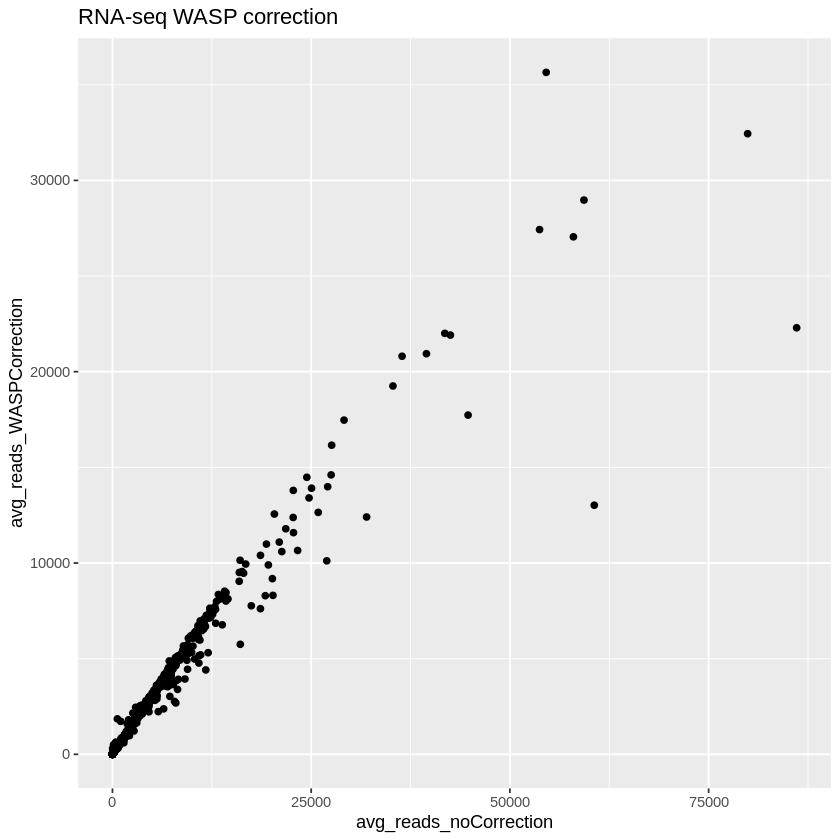

In [9]:
#### check the results of WASP correction for RNA-seq.

library(data.table)

setwd("~/spivakov/HRJ_monocytes/eqtls/WASP/mono_34reps/total_counts")
#counts <- readRDS("featureCounts_mono34reps.Rds")
#print(counts$counts)
#mycounts <- fread("./featureCounts_mono34reps.txt", )
#print(mycounts)


### Check how the counts looked last time.

orig <- fread("~/spivakov/HRJ_monocytes/eqtls/normalise_for_leo/submission_25thMay2022/eGenes_RNA_counts_untransformed.txt")
#print(head(orig))

### So we need to do the following:
### Change the gene name using the ensembl94 table
### Get the gene location, also using the first ensembl94 table that I had with gene start/end
### Change the sample names to the names of this table.

genes_locs <- fread("~/spivakov/HRJ_monocytes/external_data/ensembl/ensembl94_hg38_geneStartEnd.txt")
genes_locs[, feature := paste(`Gene stable ID`, `HGNC symbol`, sep = "_")]
genes_locs[, chr_pos := paste(`Chromosome/scaffold name`, `Gene start (bp)`, sep = ":")]
genes_locs[, hg38_location := paste(`chr_pos`, `Gene end (bp)`, sep = ":")]
genes_locs_join <- unique(genes_locs[, .(`Gene stable ID`, feature, hg38_location)])
names(genes_locs_join)[1] = "GeneID"
#print(head(genes_locs_join))

### Join to the new results 
# wasp1 <- fread("./featureCounts_mono34reps.txt")
# then I was trying with results of multimapped
# wasp2 <- fread("./featureCounts_mono34reps_multiFeatures.txt")
# now I am trying with results of GFT file - THIS IS THE ONE I USE
wasp <- fread("./featureCounts_mono34reps_GTF.txt")
# now I am trying with results of multimapped to GTF file
# wasp3 <- fread("./featureCounts_mono34reps_multiFeatures_GTF.txt")

#print(head(wasp))

wasp_feat <- wasp[genes_locs_join, on = "GeneID", nomatch = NULL]
nrow(wasp)
nrow(wasp_feat) # from 56264 to 56373, probably because some ENSG IDs have more than one gene name. Will also compare with the old results.
wasp_feat_inOld <- wasp_feat[feature %in% orig$feature]
nrow(wasp_feat_inOld) # 4742 - probably because I filtered onto the number of reads.
nrow(orig) # we had 4762 lines and now we have 4742, that seems OK

### Get the average no. reads across the table
mySamples1 <- names(orig[, 3:36])
print(head(orig))
orig[, avg_reads := rowMeans(.SD), .SDcols = c(mySamples1)]

mySamples2 <- names(wasp_feat_inOld[, 2:35])
wasp_feat_inOld[, avg_reads := rowMeans(.SD), .SDcols = c(mySamples2)]

myfeats <- unique(orig$feature)
myfeatsSampled <- sample(myfeats, 4762) # this is the number of genes anyway

old_sampled <- orig[feature %in% myfeatsSampled]
new_sampled <- wasp_feat_inOld[feature %in% myfeatsSampled]

setnames(old_sampled, "avg_reads", "avg_reads_noCorrection")
setnames(new_sampled, "avg_reads", "avg_reads_WASPCorrection")

old_sampled_plot <- unique(old_sampled[, .(feature, avg_reads_noCorrection)])
new_sampled_plot <- unique(new_sampled[, .(feature, avg_reads_WASPCorrection)])

to_plot <- old_sampled_plot[new_sampled_plot, on = "feature", nomatch = NULL]

print(to_plot)

library(ggplot2)
pdf(file = "./RNA_WASP_comparison_with_no_correction.pdf")
p <- ggplot(to_plot, aes(x = avg_reads_noCorrection, y = avg_reads_WASPCorrection)) + geom_point() +
       ggtitle("RNA-seq WASP correction")
print(p)
dev.off()

print(p)

pearson <- cor(to_plot$avg_reads_noCorrection, to_plot$avg_reads_WASPCorrection, method = 'pearson')
pearson
spearman <- cor(to_plot$avg_reads_noCorrection, to_plot$avg_reads_WASPCorrection, method = 'spearman')
spearman

## Looks OK! but investigate why some go to zero (See next chunk)
## When we allow for multiple overlaps, we don't get any more at zero. However, we get some that have MORE reads than previously.
## Now with GFT it looks a lot better.
## Look at the multiple overlaps GFT, out of interest.
## Again, sometimes there were genes with too many reads.
## So we stick with the GTF single overlaps method.

[1] 56264

[1] 56273

[1] 4742

[1] 4762

                   feature          hg38_location S025NM S025QG S025RE S025SC
1:    ENSG00000213341_CHUK 10:100188298:100229619    802    551    579    506
2: ENSG00000095485_CWF19L1 10:100232298:100267680    814    600    613    498
3:  ENSG00000107593_PKD2L1 10:100288154:100330486      8      5      4      7
4:    ENSG00000119906_SLF2 10:100912569:100965136    513    274    378    446
5:  ENSG00000055950_MRPL43 10:100969458:100987515    233    183    240    297
6:    ENSG00000107833_NPM3 10:101781325:101783413     46     35     55     41
   S025TA S025U8 S025V6 S025W4 S025X2 S025Y0 S0260R S0262N S0263L S0264J S0265H
1:    665    504    689    815    690    537    709    527    523    751    579
2:    656    531    740   1049    542    716    616    531    720    758    576
3:      5      9     18      6     13      1      6      7      9      8      9
4:    574    495    647    612    497    469    485    444    358    323    240
5:    302    244    367    394    392    367    372   

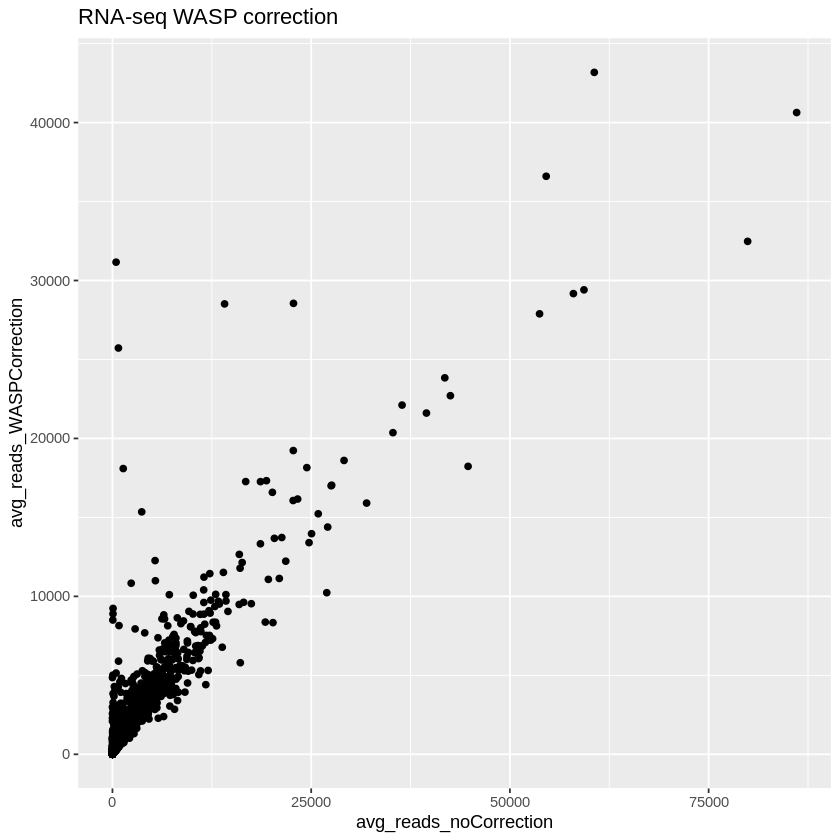

[1] 0.9011624

[1] 0.919161

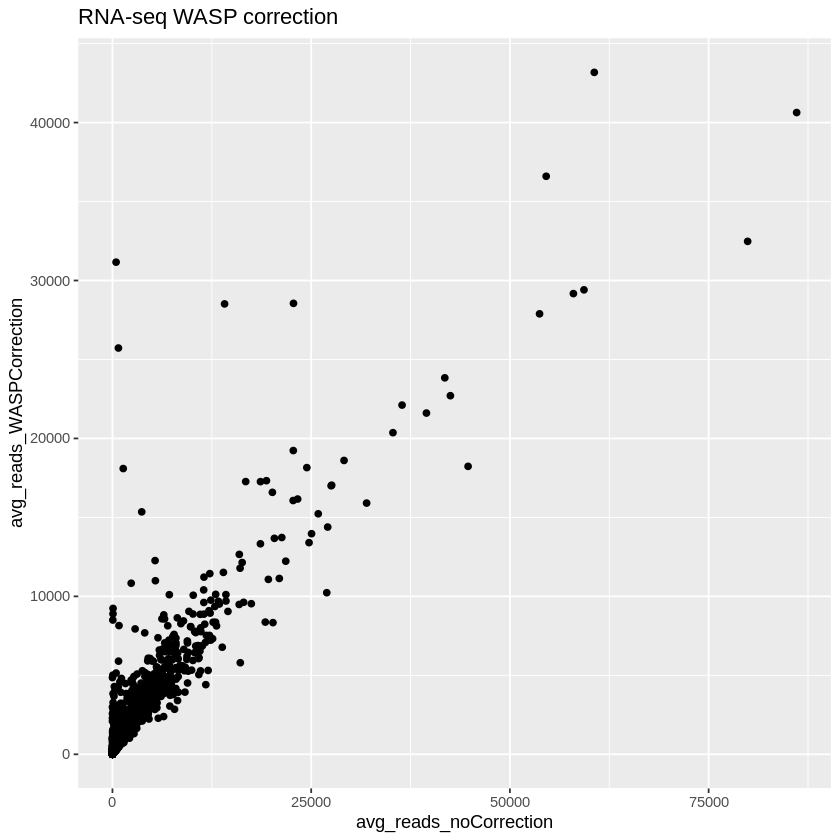

In [53]:
### Checking the genes that went to zero before allowing for multimapping:
to_plot[feature %like% "BTBD1"]
to_plot[feature %like% "EBLN2"]
to_plot[feature %like% "CENPS"]
to_plot[feature %like% "LILRB3"]
to_plot[feature %like% "CITED2"]

### It is better, but how should we use the featureCounts settings?


feature,avg_reads_noCorrection,avg_reads_WASPCorrection
<chr>,<dbl>,<dbl>
ENSG00000064726_BTBD1,1069.5882,1192.2647
ENSG00000148925_BTBD10,105.1176,171.0882
ENSG00000176595_KBTBD11,1363.9412,839.2059


feature,avg_reads_noCorrection,avg_reads_WASPCorrection
<chr>,<dbl>,<dbl>
ENSG00000255423_EBLN2,152.3824,102.1765


feature,avg_reads_noCorrection,avg_reads_WASPCorrection
<chr>,<dbl>,<dbl>
ENSG00000175279_CENPS,1.529412,6.5


feature,avg_reads_noCorrection,avg_reads_WASPCorrection
<chr>,<dbl>,<dbl>
ENSG00000204577_LILRB3,3480.118,2780.618


feature,avg_reads_noCorrection,avg_reads_WASPCorrection
<chr>,<dbl>,<dbl>
ENSG00000164442_CITED2,1992,1263.382


In [51]:
#print(to_plot[avg_reads_WASPCorrection == 0])
genes_transcripts <- fread("~/spivakov/HRJ_monocytes/external_data/ensembl/ensembl94_transcript_coords_hg38_strand.txt")
#print(genes_transcripts)

### BTBD1: same ENSGID; the counts all genuinely go to zero
genes_locs_join[feature %like% "BTBD1"]
genes_transcripts[`HGNC symbol` == "BTBD1"]
orig[feature %like% "BTBD1"]
wasp_feat[feature %like% "BTBD1"]
wasp_feat[feature %like% "ENSG00000064726"] # this is the ENSG ID

### EBLN2: same ENSGID; the counts all genuinely go to zero
genes_locs_join[feature %like% "EBLN2"]
genes_transcripts[`HGNC symbol` == "EBLN2"]
orig[feature %like% "EBLN2"]
wasp_feat[feature %like% "EBLN2"]

### CENPS: same ENSGID; the counts all genuinely go to zero
genes_locs_join[feature %like% "CENPS"]
genes_transcripts[`HGNC symbol` == "CENPS"]
orig[feature %like% "CENPS"]
wasp_feat[feature %like% "CENPS"]

### LILRB3: same ENSGID; the counts all genuinely go to zero
genes_locs_join[feature %like% "LILRB3"]
genes_transcripts[`HGNC symbol` == "LILRB3"]
orig[feature %like% "LILRB3"]
wasp_feat[feature %like% "LILRB3"]

### CITED2: same ENSGID; the counts all genuinely go to zero
genes_locs_join[feature %like% "CITED2"]
genes_transcripts[`HGNC symbol` == "CITED2"]
orig[feature %like% "CITED2"]
wasp_feat[feature %like% "CITED2"]

### Now check these regions in WASP reports

GeneID,feature,hg38_location
<chr>,<chr>,<chr>
ENSG00000064726,ENSG00000064726_BTBD1,15:83016422:83067354
ENSG00000234438,ENSG00000234438_KBTBD13,15:65076816:65079939
ENSG00000273645,ENSG00000273645_KBTBD11,CHR_HSCHR8_8_CTG1:1973878:2006936
ENSG00000187715,ENSG00000187715_KBTBD12,3:127915232:127987671
ENSG00000219433,ENSG00000219433_BTBD10P2,6:149794763:149795746
ENSG00000257675,ENSG00000257675_BTBD10P1,12:52748776:52750127
ENSG00000148925,ENSG00000148925_BTBD10,11:13388001:13463297
ENSG00000253696,ENSG00000253696_KBTBD11-OT1,8:1971397:1976478
ENSG00000176595,ENSG00000176595_KBTBD11,8:1973878:2006936


Gene stable ID,Transcript stable ID,HGNC symbol,Transcript start (bp),Transcript end (bp),Chromosome/scaffold name,Strand
<chr>,<chr>,<chr>,<int>,<int>,<chr>,<int>
ENSG00000064726,ENST00000261721,BTBD1,83016422,83067354,15,-1
ENSG00000064726,ENST00000379403,BTBD1,83017961,83067151,15,-1
ENSG00000064726,ENST00000559652,BTBD1,83018740,83056479,15,-1
ENSG00000064726,ENST00000558344,BTBD1,83020746,83030766,15,-1
ENSG00000064726,ENST00000560015,BTBD1,83029543,83041821,15,-1


feature,hg38_location,S025NM,S025QG,S025RE,S025SC,S025TA,S025U8,S025V6,S025W4,⋯,S026KO,S026MK,S026NI,S026S8,S026T6,S026XZ,S026YX,S0270N,S0271L,avg_reads
<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>
ENSG00000148925_BTBD10,11:13388001:13463297,132,46,81,74,117,90,130,129,⋯,82,116,131,95,160,58,169,113,90,105.1176
ENSG00000064726_BTBD1,15:83016422:83067354,1382,730,1042,1028,1220,877,1153,1369,⋯,1062,1592,970,661,1966,963,1022,1372,834,1069.5882
ENSG00000176595_KBTBD11,8:1973878:2006936,638,727,849,951,1050,585,549,1360,⋯,1643,2532,1481,1092,2969,856,701,1935,913,1363.9412


GeneID,S025NM-01.keep.merge.unique.sort.bam,S025QG-02.keep.merge.unique.sort.bam,S025RE-03.keep.merge.unique.sort.bam,S025SC-04.keep.merge.unique.sort.bam,S025TA-05.keep.merge.unique.sort.bam,S025U8-06.keep.merge.unique.sort.bam,S025V6-07.keep.merge.unique.sort.bam,S025W4-08.keep.merge.unique.sort.bam,S025X2-09.keep.merge.unique.sort.bam,⋯,S026MK-27.keep.merge.unique.sort.bam,S026NI-28.keep.merge.unique.sort.bam,S026S8-29.keep.merge.unique.sort.bam,S026T6-30.keep.merge.unique.sort.bam,S026XZ-31.keep.merge.unique.sort.bam,S026YX-32.keep.merge.unique.sort.bam,S0270N-33.keep.merge.unique.sort.bam,S0271L-34.keep.merge.unique.sort.bam,feature,hg38_location
<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<chr>,<chr>
ENSG00000064726,1715,890,1252,1185,1350,1196,1351,1708,1164,⋯,1515,951,743,1233,1441,1145,1592,1075,ENSG00000064726_BTBD1,15:83016422:83067354
ENSG00000234438,0,0,0,0,0,0,0,0,1,⋯,0,0,0,0,1,1,0,0,ENSG00000234438_KBTBD13,15:65076816:65079939
ENSG00000187715,2,0,1,1,1,1,4,1,1,⋯,2,0,2,1,3,1,1,0,ENSG00000187715_KBTBD12,3:127915232:127987671
ENSG00000219433,2,0,1,1,1,1,0,2,2,⋯,4,0,0,2,3,1,2,3,ENSG00000219433_BTBD10P2,6:149794763:149795746
ENSG00000257675,0,0,0,0,0,0,1,0,0,⋯,0,0,0,0,0,0,0,0,ENSG00000257675_BTBD10P1,12:52748776:52750127
ENSG00000148925,251,102,132,158,178,158,231,246,259,⋯,194,141,148,140,152,217,171,180,ENSG00000148925_BTBD10,11:13388001:13463297
ENSG00000253696,2,2,3,2,5,1,1,7,2,⋯,6,1,1,6,0,3,6,1,ENSG00000253696_KBTBD11-OT1,8:1971397:1976478
ENSG00000176595,405,519,513,601,709,440,387,898,1320,⋯,1334,868,741,947,585,505,1293,680,ENSG00000176595_KBTBD11,8:1973878:2006936
ENSG00000204347,0,0,0,0,1,0,0,0,0,⋯,0,0,0,1,1,0,1,0,ENSG00000204347_BTBD17,17:74356416:74361946


GeneID,S025NM-01.keep.merge.unique.sort.bam,S025QG-02.keep.merge.unique.sort.bam,S025RE-03.keep.merge.unique.sort.bam,S025SC-04.keep.merge.unique.sort.bam,S025TA-05.keep.merge.unique.sort.bam,S025U8-06.keep.merge.unique.sort.bam,S025V6-07.keep.merge.unique.sort.bam,S025W4-08.keep.merge.unique.sort.bam,S025X2-09.keep.merge.unique.sort.bam,⋯,S026MK-27.keep.merge.unique.sort.bam,S026NI-28.keep.merge.unique.sort.bam,S026S8-29.keep.merge.unique.sort.bam,S026T6-30.keep.merge.unique.sort.bam,S026XZ-31.keep.merge.unique.sort.bam,S026YX-32.keep.merge.unique.sort.bam,S0270N-33.keep.merge.unique.sort.bam,S0271L-34.keep.merge.unique.sort.bam,feature,hg38_location
<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<chr>,<chr>
ENSG00000064726,1715,890,1252,1185,1350,1196,1351,1708,1164,⋯,1515,951,743,1233,1441,1145,1592,1075,ENSG00000064726_BTBD1,15:83016422:83067354


GeneID,feature,hg38_location
<chr>,<chr>,<chr>
ENSG00000255423,ENSG00000255423_EBLN2,3:73061659:73063337


Gene stable ID,Transcript stable ID,HGNC symbol,Transcript start (bp),Transcript end (bp),Chromosome/scaffold name,Strand
<chr>,<chr>,<chr>,<int>,<int>,<chr>,<int>
ENSG00000255423,ENST00000533473,EBLN2,73061659,73063337,3,1


feature,hg38_location,S025NM,S025QG,S025RE,S025SC,S025TA,S025U8,S025V6,S025W4,⋯,S026KO,S026MK,S026NI,S026S8,S026T6,S026XZ,S026YX,S0270N,S0271L,avg_reads
<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>
ENSG00000255423_EBLN2,3:73061659:73063337,187,104,140,110,148,163,196,152,⋯,113,253,109,88,268,154,128,178,145,152.3824


GeneID,S025NM-01.keep.merge.unique.sort.bam,S025QG-02.keep.merge.unique.sort.bam,S025RE-03.keep.merge.unique.sort.bam,S025SC-04.keep.merge.unique.sort.bam,S025TA-05.keep.merge.unique.sort.bam,S025U8-06.keep.merge.unique.sort.bam,S025V6-07.keep.merge.unique.sort.bam,S025W4-08.keep.merge.unique.sort.bam,S025X2-09.keep.merge.unique.sort.bam,⋯,S026MK-27.keep.merge.unique.sort.bam,S026NI-28.keep.merge.unique.sort.bam,S026S8-29.keep.merge.unique.sort.bam,S026T6-30.keep.merge.unique.sort.bam,S026XZ-31.keep.merge.unique.sort.bam,S026YX-32.keep.merge.unique.sort.bam,S0270N-33.keep.merge.unique.sort.bam,S0271L-34.keep.merge.unique.sort.bam,feature,hg38_location
<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<chr>,<chr>
ENSG00000255423,127,78,96,77,103,120,141,109,120,⋯,146,72,64,92,117,97,123,113,ENSG00000255423_EBLN2,3:73061659:73063337


GeneID,feature,hg38_location
<chr>,<chr>,<chr>
ENSG00000251503,ENSG00000251503_CENPS-CORT,1:10430102:10452153
ENSG00000175279,ENSG00000175279_CENPS,1:10430443:10442809


Gene stable ID,Transcript stable ID,HGNC symbol,Transcript start (bp),Transcript end (bp),Chromosome/scaffold name,Strand
<chr>,<chr>,<chr>,<int>,<int>,<chr>,<int>
ENSG00000175279,ENST00000309048,CENPS,10430443,10442809,1,1
ENSG00000175279,ENST00000602486,CENPS,10430512,10431130,1,1
ENSG00000175279,ENST00000477755,CENPS,10430783,10442334,1,1
ENSG00000175279,ENST00000462462,CENPS,10431123,10442502,1,1
ENSG00000175279,ENST00000464507,CENPS,10440123,10442657,1,1


feature,hg38_location,S025NM,S025QG,S025RE,S025SC,S025TA,S025U8,S025V6,S025W4,⋯,S026KO,S026MK,S026NI,S026S8,S026T6,S026XZ,S026YX,S0270N,S0271L,avg_reads
<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>
ENSG00000175279_CENPS,1:10430443:10442809,0,0,0,1,7,0,0,0,⋯,1,0,0,0,3,2,1,4,1,1.529412


GeneID,S025NM-01.keep.merge.unique.sort.bam,S025QG-02.keep.merge.unique.sort.bam,S025RE-03.keep.merge.unique.sort.bam,S025SC-04.keep.merge.unique.sort.bam,S025TA-05.keep.merge.unique.sort.bam,S025U8-06.keep.merge.unique.sort.bam,S025V6-07.keep.merge.unique.sort.bam,S025W4-08.keep.merge.unique.sort.bam,S025X2-09.keep.merge.unique.sort.bam,⋯,S026MK-27.keep.merge.unique.sort.bam,S026NI-28.keep.merge.unique.sort.bam,S026S8-29.keep.merge.unique.sort.bam,S026T6-30.keep.merge.unique.sort.bam,S026XZ-31.keep.merge.unique.sort.bam,S026YX-32.keep.merge.unique.sort.bam,S0270N-33.keep.merge.unique.sort.bam,S0271L-34.keep.merge.unique.sort.bam,feature,hg38_location
<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<chr>,<chr>
ENSG00000251503,12,7,5,12,9,13,20,11,16,⋯,6,8,6,11,11,13,15,12,ENSG00000251503_CENPS-CORT,1:10430102:10452153
ENSG00000175279,4,4,3,8,7,7,15,6,10,⋯,2,2,3,8,6,12,9,8,ENSG00000175279_CENPS,1:10430443:10442809


GeneID,feature,hg38_location
<chr>,<chr>,<chr>
ENSG00000274587,ENSG00000274587_LILRB3,CHR_HSCHR19_4_CTG3_1:54217271:54223706
ENSG00000277816,ENSG00000277816_LILRB3,CHR_HSCHR19LRC_COX1_CTG3_1:54217107:54223520
ENSG00000275019,ENSG00000275019_LILRB3,CHR_HSCHR19LRC_PGF1_CTG3_1:54217293:54223789
ENSG00000204577,ENSG00000204577_LILRB3,19:54216278:54223506


Gene stable ID,Transcript stable ID,HGNC symbol,Transcript start (bp),Transcript end (bp),Chromosome/scaffold name,Strand
<chr>,<chr>,<chr>,<int>,<int>,<chr>,<int>
ENSG00000274587,ENST00000610675,LILRB3,54217271,54223597,CHR_HSCHR19_4_CTG3_1,-1
ENSG00000274587,ENST00000611086,LILRB3,54217481,54223675,CHR_HSCHR19_4_CTG3_1,-1
ENSG00000274587,ENST00000621660,LILRB3,54217544,54223597,CHR_HSCHR19_4_CTG3_1,-1
ENSG00000274587,ENST00000613710,LILRB3,54217544,54223597,CHR_HSCHR19_4_CTG3_1,-1
ENSG00000274587,ENST00000622425,LILRB3,54217712,54218314,CHR_HSCHR19_4_CTG3_1,-1
ENSG00000274587,ENST00000614962,LILRB3,54219211,54219971,CHR_HSCHR19_4_CTG3_1,-1
ENSG00000274587,ENST00000616782,LILRB3,54220458,54223626,CHR_HSCHR19_4_CTG3_1,-1
ENSG00000274587,ENST00000622778,LILRB3,54222897,54223706,CHR_HSCHR19_4_CTG3_1,-1
ENSG00000277816,ENST00000615764,LILRB3,54217361,54223411,CHR_HSCHR19LRC_COX1_CTG3_1,-1


feature,hg38_location,S025NM,S025QG,S025RE,S025SC,S025TA,S025U8,S025V6,S025W4,⋯,S026KO,S026MK,S026NI,S026S8,S026T6,S026XZ,S026YX,S0270N,S0271L,avg_reads
<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>
ENSG00000204577_LILRB3,19:54216278:54223506,3169,3223,3127,3431,4586,4368,4174,5938,⋯,1732,2834,3425,2512,3566,2106,6458,4155,2800,3480.118


GeneID,S025NM-01.keep.merge.unique.sort.bam,S025QG-02.keep.merge.unique.sort.bam,S025RE-03.keep.merge.unique.sort.bam,S025SC-04.keep.merge.unique.sort.bam,S025TA-05.keep.merge.unique.sort.bam,S025U8-06.keep.merge.unique.sort.bam,S025V6-07.keep.merge.unique.sort.bam,S025W4-08.keep.merge.unique.sort.bam,S025X2-09.keep.merge.unique.sort.bam,⋯,S026MK-27.keep.merge.unique.sort.bam,S026NI-28.keep.merge.unique.sort.bam,S026S8-29.keep.merge.unique.sort.bam,S026T6-30.keep.merge.unique.sort.bam,S026XZ-31.keep.merge.unique.sort.bam,S026YX-32.keep.merge.unique.sort.bam,S0270N-33.keep.merge.unique.sort.bam,S0271L-34.keep.merge.unique.sort.bam,feature,hg38_location
<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<chr>,<chr>
ENSG00000204577,2510,2648,2331,2606,3862,3231,3771,4522,4101,⋯,1728,2806,2352,1964,2088,5311,3262,2588,ENSG00000204577_LILRB3,19:54216278:54223506


GeneID,feature,hg38_location
<chr>,<chr>,<chr>
ENSG00000164442,ENSG00000164442_CITED2,6:139371807:139374620


Gene stable ID,Transcript stable ID,HGNC symbol,Transcript start (bp),Transcript end (bp),Chromosome/scaffold name,Strand
<chr>,<chr>,<chr>,<int>,<int>,<chr>,<int>
ENSG00000164442,ENST00000367651,CITED2,139371807,139374620,6,-1
ENSG00000164442,ENST00000537332,CITED2,139372255,139374213,6,-1
ENSG00000164442,ENST00000536159,CITED2,139372255,139374362,6,-1
ENSG00000164442,ENST00000618718,CITED2,139373074,139374605,6,-1


feature,hg38_location,S025NM,S025QG,S025RE,S025SC,S025TA,S025U8,S025V6,S025W4,⋯,S026KO,S026MK,S026NI,S026S8,S026T6,S026XZ,S026YX,S0270N,S0271L,avg_reads
<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>
ENSG00000164442_CITED2,6:139371807:139374620,1559,3605,1881,1754,1799,1525,3660,1322,⋯,897,1466,1743,3530,2690,854,1887,1201,2270,1992


GeneID,S025NM-01.keep.merge.unique.sort.bam,S025QG-02.keep.merge.unique.sort.bam,S025RE-03.keep.merge.unique.sort.bam,S025SC-04.keep.merge.unique.sort.bam,S025TA-05.keep.merge.unique.sort.bam,S025U8-06.keep.merge.unique.sort.bam,S025V6-07.keep.merge.unique.sort.bam,S025W4-08.keep.merge.unique.sort.bam,S025X2-09.keep.merge.unique.sort.bam,⋯,S026MK-27.keep.merge.unique.sort.bam,S026NI-28.keep.merge.unique.sort.bam,S026S8-29.keep.merge.unique.sort.bam,S026T6-30.keep.merge.unique.sort.bam,S026XZ-31.keep.merge.unique.sort.bam,S026YX-32.keep.merge.unique.sort.bam,S0270N-33.keep.merge.unique.sort.bam,S0271L-34.keep.merge.unique.sort.bam,feature,hg38_location
<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<chr>,<chr>
ENSG00000164442,1046,2604,1150,1082,1184,1052,2350,851,4067,⋯,766,991,2276,1166,584,1314,851,1550,ENSG00000164442_CITED2,6:139371807:139374620


In [2]:
library(Rsubread)
?featureCounts

featureCounts {Rsubread},R Documentation
files,a character vector giving names of input files containing read mapping results. The files can be in either SAM format or BAM format. The file format is automatically detected by the function.
annot.inbuilt,"a character string specifying an in-built annotation used for read summarization. It has four possible values including ""mm10"", ""mm9"", ""hg38"" and ""hg19"", corresponding to the NCBI RefSeq annotations for genomes ‘mm10’, ‘mm9’, ‘hg38’ and ‘hg19’, respectively. ""mm10"" by default. The in-built annotation has a SAF format (see below)."
annot.ext,"A character string giving name of a user-provided annotation file or a data frame including user-provided annotation data. If the annotation is in GTF format, it can only be provided as a file. If it is in SAF format, it can be provided as a file or a data frame. See below for more details about SAF format annotation. If an annotation file is provided, it can be uncompressed or gzip compressed. Note that annot.ext will override annot.inbuilt if both provided."
isGTFAnnotationFile,logical indicating whether the annotation provided via the annot.ext argument is in GTF format or not. FALSE by default. This option is only applicable when annot.ext is not NULL.
GTF.featureType,"a character string or a vector of character strings giving the feature type or types used to select rows in the GTF annotation which will be used for read summarization. ""exon"" by default. This argument is only applicable when isGTFAnnotationFile is TRUE. Feature types can be found in the third column of a GTF annotation."
GTF.attrType,"a character string giving the attribute type in the GTF annotation which will be used to group features (eg. exons) into meta-features (eg. genes). ""gene_id"" by default. This argument is only applicable when isGTFAnnotationFile is TRUE. Attributes can be found in the ninth column of a GTF annotation."
GTF.attrType.extra,a character vector specifying extra GTF attribute types that will also be included in the counting output. These attribute types will not be used to group features. NULL by default.
chrAliases,a character string giving the name of a chromosome name alias file. This should be a two-column comma-delimited text file. Chromosome name aliases included in this file are used to match chr names in annotation with those in the reads. First column in the file should include chr names in the annotation and second column should include chr names in the reads. Chr names are case sensitive. No column header should be included in the file.
useMetaFeatures,"logical indicating whether the read summarization should be performed at the feature level (eg. exons) or meta-feature level (eg. genes). If TRUE, features in the annotation (each row is a feature) will be grouped into meta-features, using their values in the GeneID column in the SAF-format annotation file or using the GTF.attrType attribute in the GTF-format annotation file, and then reads will be assiged to the meta-features instead of the features. See below for more details."
allowMultiOverlap,logical indicating if a read is allowed to be assigned to more than one feature (or meta-feature) if it is found to overlap with more than one feature (or meta-feature). FALSE by default.
